# Sentiment Analysis in Python

This notebook is part of a tutorial that can be found on my [youtube channel here](https://www.youtube.com/channel/UCxladMszXan-jfgzyeIMyvw), please check it out!

In this notebook we will be doing some sentiment analysis in python using two different techniques:
1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from 🤗
3. Huggingface Pipeline

# Step 0. Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [15]:

df = pd.read_csv('clothes.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(300000, 5)
(500, 5)


In [16]:
df.head()

,idx,reviewText,overall,summary,class
0,0,"Un reloj muy bonito, puede ser usado con traje...",4,Buen reloj por ese precio!!!,1
1,1,"I was so glad when these finally arrived, but ...",2,disappointed...,0
2,2,I ordered these boots and received them in the...,5,UGG classic sand boots ordered at Amazon,1
3,3,"Rolls below the bust line, did not expect it t...",3,product reveiw,0
4,4,Well constructed garment with plenty of interi...,5,Plenty of room,1


## Quick EDA

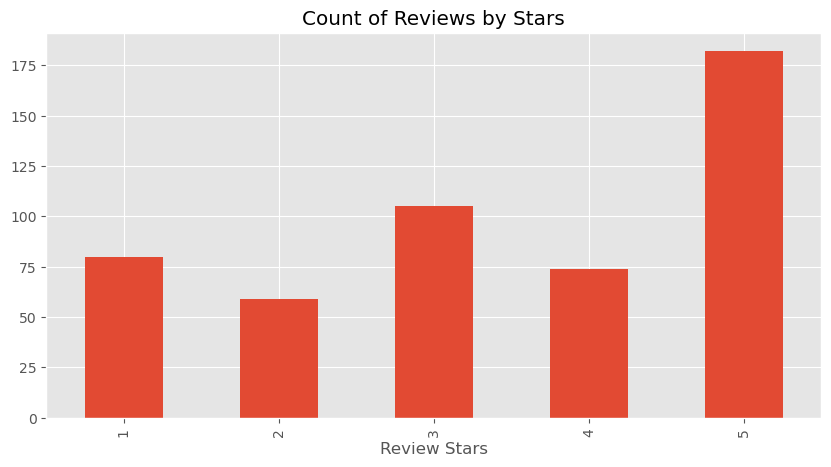

In [17]:
ax = df['overall'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

## Basic NLTK

In [18]:
example = df['reviewText'][50]
print(example)

I purchased this watch June 2007, water has gotten into it and has fogged the dial. I have contacted Swiss Army and I am waiting for their reply.  It's a shame, I've had Swiss Army watches that lasted 10 years +.


In [19]:
tokens = nltk.word_tokenize(example)
tokens

['I',
 'purchased',
 'this',
 'watch',
 'June',
 '2007',
 ',',
 'water',
 'has',
 'gotten',
 'into',
 'it',
 'and',
 'has',
 'fogged',
 'the',
 'dial',
 '.',
 'I',
 'have',
 'contacted',
 'Swiss',
 'Army',
 'and',
 'I',
 'am',
 'waiting',
 'for',
 'their',
 'reply',
 '.',
 'It',
 "'s",
 'a',
 'shame',
 ',',
 'I',
 "'ve",
 'had',
 'Swiss',
 'Army',
 'watches',
 'that',
 'lasted',
 '10',
 'years',
 '+',
 '.']

In [20]:
tagged = nltk.pos_tag(tokens)
tagged

[('I', 'PRP'),
 ('purchased', 'VBD'),
 ('this', 'DT'),
 ('watch', 'NN'),
 ('June', 'NNP'),
 ('2007', 'CD'),
 (',', ','),
 ('water', 'NN'),
 ('has', 'VBZ'),
 ('gotten', 'VBN'),
 ('into', 'IN'),
 ('it', 'PRP'),
 ('and', 'CC'),
 ('has', 'VBZ'),
 ('fogged', 'VBN'),
 ('the', 'DT'),
 ('dial', 'NN'),
 ('.', '.'),
 ('I', 'PRP'),
 ('have', 'VBP'),
 ('contacted', 'VBN'),
 ('Swiss', 'JJ'),
 ('Army', 'NNP'),
 ('and', 'CC'),
 ('I', 'PRP'),
 ('am', 'VBP'),
 ('waiting', 'VBG'),
 ('for', 'IN'),
 ('their', 'PRP$'),
 ('reply', 'NN'),
 ('.', '.'),
 ('It', 'PRP'),
 ("'s", 'VBZ'),
 ('a', 'DT'),
 ('shame', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'ve", 'VBP'),
 ('had', 'VBD'),
 ('Swiss', 'JJ'),
 ('Army', 'NNP'),
 ('watches', 'NNS'),
 ('that', 'WDT'),
 ('lasted', 'VBD'),
 ('10', 'CD'),
 ('years', 'NNS'),
 ('+', 'RB'),
 ('.', '.')]

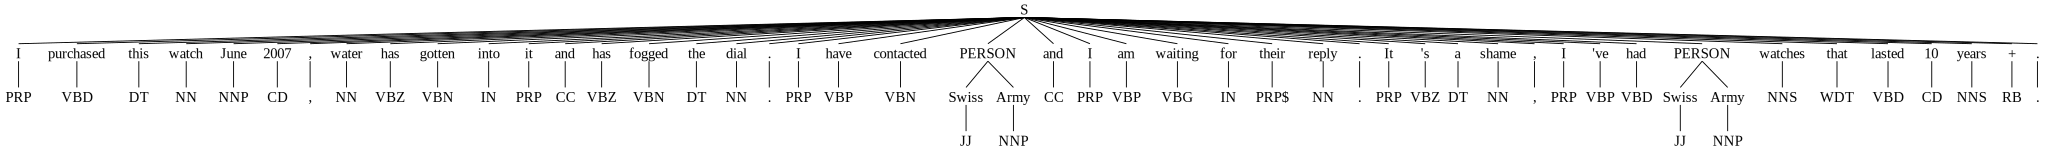

In [21]:
entities = nltk.chunk.ne_chunk(tagged)
entities

# Step 1. VADER Seniment Scoring

We will use NLTK's `SentimentIntensityAnalyzer` to get the neg/neu/pos scores of the text.

- This uses a "bag of words" approach:
    1. Stop words are removed
    2. each word is scored and combined to a total score.

In [22]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dai/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [24]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [25]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [26]:
sia.polarity_scores(example)

{'neg': 0.079, 'neu': 0.921, 'pos': 0.0, 'compound': -0.4767}

In [27]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['reviewText']
    myid = row['idx']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
vaders = pd.DataFrame(res).T
# vaders = vaders.reset_index().rename(columns={'index': 'Id'})
# vaders = vaders.merge(df, how='left')
vaders

,neg,neu,pos,compound
0,0.069,0.875,0.056,-0.1027
1,0.094,0.709,0.197,0.9640
2,0.000,0.809,0.191,0.7783
3,0.000,1.000,0.000,0.0000
4,0.000,0.889,0.111,0.5423
...,...,...,...,...
495,0.000,0.893,0.107,0.5023
496,0.067,0.798,0.134,0.4749
497,0.037,0.793,0.170,0.7337
498,0.188,0.611,0.201,-0.1029


## Plot VADER results

In [29]:
df = pd.concat([df,vaders],axis=1)

In [30]:
df.overall = df.overall.astype('Int64')

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   idx         500 non-null    int64  
 1   reviewText  500 non-null    object 
 2   overall     500 non-null    Int64  
 3   summary     500 non-null    object 
 4   class       500 non-null    int64  
 5   neg         500 non-null    float64
 6   neu         500 non-null    float64
 7   pos         500 non-null    float64
 8   compound    500 non-null    float64
dtypes: Int64(1), float64(4), int64(2), object(2)
memory usage: 35.8+ KB


In [32]:
df.dropna(inplace=True)

/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


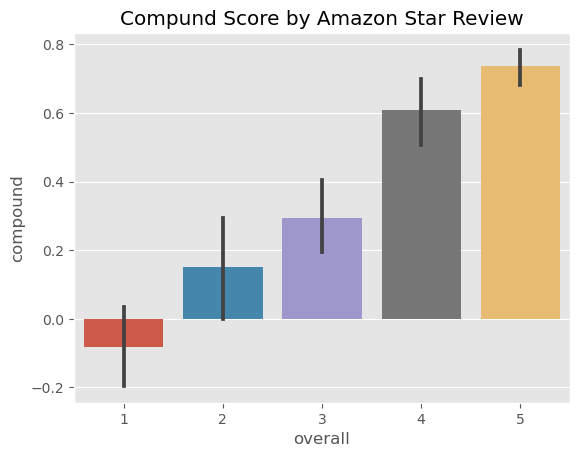

In [33]:
ax = sns.barplot(data=df, x='overall', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


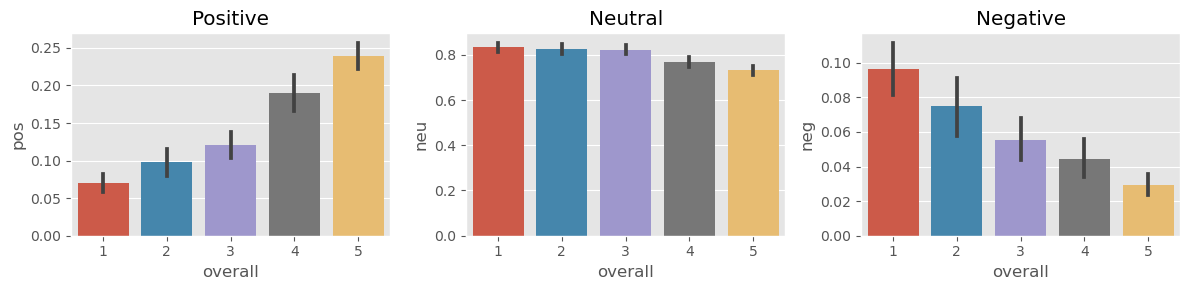

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df, x='overall', y='pos', ax=axs[0])
sns.barplot(data=df, x='overall', y='neu', ax=axs[1])
sns.barplot(data=df, x='overall', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 3. Roberta Pretrained Model

- Use a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [35]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [36]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [37]:
# VADER results on example
print(example)
sia.polarity_scores(example)

I purchased this watch June 2007, water has gotten into it and has fogged the dial. I have contacted Swiss Army and I am waiting for their reply.  It's a shame, I've had Swiss Army watches that lasted 10 years +.


{'neg': 0.079, 'neu': 0.921, 'pos': 0.0, 'compound': -0.4767}

In [60]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
res=np.argmax(scores)
if res==0:
    print("Negative")
elif res==1 or res==2:
    print("Positive")

scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

Negative
{'roberta_neg': 0.76403266, 'roberta_neu': 0.2131396, 'roberta_pos': 0.022827698}


In [61]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    # scores_dict = {
    #     'roberta_neg' : scores[0],
    #     'roberta_neu' : scores[1],
    #     'roberta_pos' : scores[2]
    # }
    res=np.argmax(scores)
    if res==0:
        return "Negative"
    elif res==1 or res==2:
        return "Positive"

In [40]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['reviewText']
        myid = row['idx']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
results_df = pd.DataFrame(res).T
results_df = pd.concat([df,results_df],axis=1)

In [42]:
results_df.head()

,idx,reviewText,overall,summary,class,neg,neu,pos,compound,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,0,"Un reloj muy bonito, puede ser usado con traje...",4,Buen reloj por ese precio!!!,1,0.069,0.875,0.056,-0.1027,0.069,0.875,0.056,-0.1027,0.028223,0.652174,0.319603
1,1,"I was so glad when these finally arrived, but ...",2,disappointed...,0,0.094,0.709,0.197,0.9640,0.094,0.709,0.197,0.9640,0.235617,0.313077,0.451305
2,2,I ordered these boots and received them in the...,5,UGG classic sand boots ordered at Amazon,1,0.000,0.809,0.191,0.7783,0.000,0.809,0.191,0.7783,0.001383,0.014141,0.984476
3,3,"Rolls below the bust line, did not expect it t...",3,product reveiw,0,0.000,1.000,0.000,0.0000,0.000,1.000,0.000,0.0000,0.884773,0.107105,0.008122
4,4,Well constructed garment with plenty of interi...,5,Plenty of room,1,0.000,0.889,0.111,0.5423,0.000,0.889,0.111,0.5423,0.005812,0.210215,0.783972


## Compare Scores between models

In [43]:
results_df.columns

Index(['idx', 'reviewText', 'overall', 'summary', 'class', 'neg', 'neu', 'pos',
       'compound', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
      dtype='object')

# Step 3: Review Examples:

- Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review score differ the most.

In [44]:
results_df.query('overall == 1') \
    .sort_values('roberta_pos', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_28174/3336709947.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 1') \


'I really liked the look of the glasses...until a lens popped out. I think I will just stick to $10 sunglasses. They never seem to break or get lost.'

In [45]:
results_df.query('overall == 1') \
    .sort_values('vader_pos', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_28174/2150632289.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 1') \


'That is a nice picture they have up there.  A girl with some thigh high stockings.  Well the product they shipped had the strips like that picture for sure, but they were a unified piece of fabric that hugs the butt and goes all the way up to the waist line.  ALL THE WAY UP TO THE WAIST LINE.  Gave this as a present for Christmas today.  Imagine my surprise when I think I am giving her some nice stockings but instead get something totally different.  VERY DISPLEASED.'

In [46]:
# nevative sentiment 5-Star view

In [47]:
results_df.query('overall == 5') \
    .sort_values('roberta_neg', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_28174/1975733132.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 5') \


"Slippers came well packed and were exactly what I ordered - but I had lots of problems receiving them.  They were supposed to come by Dec 18th, however FedEx lost the package and Bench Mark Brands was not super helpful in trying to track down the package.  The slippers didn't arrive until December 30th."

In [48]:
results_df.query('overall == 5') \
    .sort_values('vader_neg', ascending=False)['reviewText'].values[0]

/tmp/ipykernel_28174/1482952078.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  results_df.query('overall == 5') \


"Slippers came well packed and were exactly what I ordered - but I had lots of problems receiving them.  They were supposed to come by Dec 18th, however FedEx lost the package and Bench Mark Brands was not super helpful in trying to track down the package.  The slippers didn't arrive until December 30th."

# Extra: The Transformers Pipeline
- Quick & easy way to run sentiment predictions

In [49]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

2024-02-16 16:14:45.352794: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 16:14:47.537344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 16:14:47.537550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-16 16:14:47.734453: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-16 16:14:48.363359: I tensorflow/core/platform/cpu_feature_guar

In [50]:
sent_pipeline('I love sentiment analysis!')

[{'label': 'POSITIVE', 'score': 0.9997853636741638}]

In [51]:
sent_pipeline('Make sure to like and subscribe!')

[{'label': 'POSITIVE', 'score': 0.9991742968559265}]

In [52]:
sent_pipeline('booo')

[{'label': 'NEGATIVE', 'score': 0.9936267137527466}]

In [53]:
output={'labels':None,'Score':None}
scr=[]
lbl=[]
for sent in df['reviewText']:
    for k in sent_pipeline(sent):
        lbl.append(k.get('label'))
        scr.append(k.get('score'))

output['labels']=np.array(lbl)
output['Score']=np.array(scr)


In [54]:
data=pd.DataFrame(output)
data.head()

,labels,Score
0,NEGATIVE,0.984317
1,POSITIVE,0.915814
2,POSITIVE,0.999775
3,NEGATIVE,0.993220
4,POSITIVE,0.990674


In [55]:
data.shape

(500, 2)

In [56]:
data.labels.value_counts()

labels
POSITIVE    254
NEGATIVE    246
Name: count, dtype: int64

In [57]:
model.save_pretrained("pretrained_sentiment_analysis_model")